# shop results

## goal

* find factors influencing this shop's results
* predict results

In [1]:
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Load data

In [2]:
from datetime import datetime, timedelta
from os import path, scandir

daily_datadir = "./data/CaisseJour/"
datadirs = [path.join(daily_datadir, d.name) for d in scandir(daily_datadir)]
data_files = [
    path.join(datadir, file.name)
    for datadir in datadirs
    for file in scandir(datadir)
]

In [3]:
def parse_caisse(filename, keywords=("Chiffre", "TVA", "nombre", "moyen", "ticket")):
    """Parse file "caisse jour"
    
    Args:
        filename (string): file to parse
        keywords (list): list of keywords for  one line data
    """
    data = {}
    with open(filename, "br") as fd:
        for line in fd:
            line = line.decode("Windows-1252",errors="ignore")
            if "à" in line:
                # try with date
                try:
                    date = [int(d) for d in  line.split(" ")[0].split("/")]
                except ValueError:
                    # "à" in cocktail name
                    continue
                data["date"] = datetime(date[2], date[1], date[0])
            elif any(keyword in line for keyword in keywords):
                value = line.split(";")[1]
                value = value.strip("€ \r\n")
                try:
                    # parse french number representation
                    value = value.replace(",", ".")
                    value = float(value)
                except ValueError:
                    # not a number, cannot convertto float
                    pass
                data[line.split(";")[0].strip()] = value
        #TODO: add small tables
    return data

In [4]:
daily = pd.DataFrame(parse_caisse(f) for f in data_files)
daily.index = daily["date"]  # keep date and index
open_days = daily["date"]

In [5]:
daily.head()

,Chiffre d'Affaires HT,Chiffre d'Affaires TTC,Coefficient moyen,Nom TVA,Nombre moyen de produits / Ticket,TVA Collecté,TVA Vente 10%,TVA Vente 20%,Ticket moyen TTC,date
date,,,,,,,,,,
2018-11-09,545.26,633.9,0.0,Taux TVA,1.6,88.64,10 %,20 %,10.06,2018-11-09
2018-11-03,242.34,285.8,0.0,Taux TVA,1.6,43.46,10 %,20 %,10.99,2018-11-03
2018-11-10,1370.21,1616.0,0.0,Taux TVA,1.8,245.79,10 %,20 %,11.14,2018-11-10
2018-11-22,153.58,182.0,0.0,Taux TVA,1.2,28.42,10 %,20 %,7.00,2018-11-22
2018-11-02,394.43,459.7,0.0,Taux TVA,1.5,65.27,10 %,20 %,10.95,2018-11-02


## Calendar

In [6]:
start_date = min(daily["date"])
end_date = max(daily["date"])

#start_date = datetime(2018, 09, 01)
#end_date = datetime(2019, 09, 01)

In [7]:
def date_to_monthweek(date):
    """Return the week number of the month, i.e. the number of mondays before this date.
    
    Args:
        date: (datetime.datetime)
        
    Return:
        int: the week number
    """
    return len(
        [
            day
            for day in pd.date_range(datetime(date.year, date.month, 1), date)
            if day.weekday() == 0
        ]
    )

In [8]:
calendar = pd.DataFrame(pd.date_range(start_date, end_date), columns=("date",))
#calendar["day", "month", "year", "wod"] = list(map(lambda x: (x.day, x.month, x.year, x.weekday()), calendar["date"]))
calendar["day"] = list(map(lambda x: x.day, calendar["date"]))
calendar["month"] = list(map(lambda x: x.month, calendar["date"]))
calendar["year"] = list(map(lambda x: x.year, calendar["date"]))
calendar["dow"] = list(map(lambda x: x.weekday(), calendar["date"]))
calendar["week number"] = list(map(lambda x: x.isocalendar()[1], calendar["date"]))
calendar["month week number"] = list(map(date_to_monthweek, calendar["date"]))

### Holidays

from https://date.nager.at/PublicHoliday/DownloadCSV/FR/2018

In [9]:
datadir = "./data/calendars"
data_files = [path.join(datadir, file.name) for file in scandir(datadir)]

holidays = pd.concat(
    [
        pd.read_csv(file) 
        for file in data_files
    ]
)

# reformat date
holidays["Date"] = pd.Series(
    [
        datetime(int(x.split("-")[0]), int(x.split("-")[1]), int(x.split("-")[2]))
        for x in holidays["Date"]
    ]
)

In [10]:
holidays.head()

,Date,LocalName,Name,CountryCode,Fixed,Global,LaunchYear
0,2018-01-01,Jour de l'an,New Year's Day,FR,True,True,1967.0
1,2018-03-30,Vendredi saint,Good Friday,FR,False,False,NaN
2,2018-04-02,Lundi de Pâques,Easter Monday,FR,False,True,1642.0
3,2018-05-01,Fête du premier mai,Labour Day,FR,True,True,NaN
4,2018-05-08,Fête de la Victoire,Victory in Europe Day,FR,True,True,NaN


In [11]:
calendar["public holidays"] = list(map(lambda x: x in list(holidays["Date"]), calendar["date"]))

In [12]:
calendar = calendar.set_index("date")

In [13]:
calendar.head()

,day,month,year,dow,week number,month week number,public holidays
date,,,,,,,
2018-08-29,29,8,2018,2,35,4,False
2018-08-30,30,8,2018,3,35,4,False
2018-08-31,31,8,2018,4,35,4,False
2018-09-01,1,9,2018,5,35,0,False
2018-09-02,2,9,2018,6,35,0,False


join data

In [14]:
# the pandas way
daily = daily.join([calendar])

# the spark.sql way
# TODO

daily.head()

,Chiffre d'Affaires HT,Chiffre d'Affaires TTC,Coefficient moyen,Nom TVA,Nombre moyen de produits / Ticket,TVA Collecté,TVA Vente 10%,TVA Vente 20%,Ticket moyen TTC,date,day,month,year,dow,week number,month week number,public holidays
date,,,,,,,,,,,,,,,,,
2018-08-29,88.99,105.6,0.0,Taux TVA,1.3,16.61,10 %,20 %,7.04,2018-08-29,29,8,2018,2,35,4,False
2018-08-30,115.37,134.1,0.0,Taux TVA,2.7,18.73,10 %,20 %,19.16,2018-08-30,30,8,2018,3,35,4,False
2018-08-31,91.39,108.3,0.0,Taux TVA,2.1,16.91,10 %,20 %,10.83,2018-08-31,31,8,2018,4,35,4,False
2018-09-01,196.80,231.7,0.0,Taux TVA,2.2,34.90,10 %,20 %,14.48,2018-09-01,1,9,2018,5,35,0,False
2018-09-05,56.00,67.2,0.0,Taux TVA,10.0,11.20,NaN,20 %,67.20,2018-09-05,5,9,2018,2,36,1,False


## Weather

from meteofrance

### Programation

In [15]:
import icalendar

In [16]:
icalfile = "./data/prog/Programmation.ics"

columns = ("DTSTAMP", "UID", "SUMMARY", "DTSTART", "DTEND")

In [17]:
with open(icalfile, "rb") as fd:
    icalcontent = fd.read()
    
events_cal = icalendar.Calendar().from_ical(icalcontent)

In [18]:
events = pd.DataFrame()
for evt in events_cal.walk('vevent'):
    
    # rebuild event
    elt = {}
    for k, v in dict(evt).items():
        elt[k] = evt[k].to_ical().decode()
    events = events.append(pd.DataFrame([elt]), sort=False)

events.head()

,DTEND,DTSTAMP,DTSTART,STATUS,SUMMARY,UID,SEQUENCE,CREATED,LAST-MODIFIED,CLASS,TRANSP,X-LIC-ERROR,DESCRIPTION,DURATION,RRULE,RECURRENCE-ID
0,20190405T200000,20190316T170758Z,20190405T190000,CONFIRMED,Régie à faire homme/femme,bce54aba-6566-48ab-a31d-8318feab67f6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,20181202T180000,20181017T124115Z,20181202T160000,CONFIRMED,Cours arbitrage anne,bdb52aeb-3bae-4bfd-b2dd-47cdb4dc1cfd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,20181213T173000,20181210T025524Z,20181213T160000,CONFIRMED,Show sculpteur,bdf96d8c-dadc-47a6-ac64-05b3d0716502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,20181115T203000,20181029T181925Z,20181115T193000,CONFIRMED,Ligue d'improvisation de la réunion -Improrun,be17ad5d-99ab-4a06-9160-3ccde3dca03b,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,20190623T210000,20190303T114938Z,20190623T193000,CONFIRMED,Clown improvisé,bfb42f8b-06d8-4ccd-88eb-57beee4218b1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# parse date
date_cols = [col for col in events.columns if col.startswith("DT")]

for col in date_cols:
    events[col] = events[col].apply(pd.to_datetime)

events.head()

,DTEND,DTSTAMP,DTSTART,STATUS,SUMMARY,UID,SEQUENCE,CREATED,LAST-MODIFIED,CLASS,TRANSP,X-LIC-ERROR,DESCRIPTION,DURATION,RRULE,RECURRENCE-ID
0,2019-04-05 20:00:00,2019-03-16 17:07:58+00:00,2019-04-05 19:00:00,CONFIRMED,Régie à faire homme/femme,bce54aba-6566-48ab-a31d-8318feab67f6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2018-12-02 18:00:00,2018-10-17 12:41:15+00:00,2018-12-02 16:00:00,CONFIRMED,Cours arbitrage anne,bdb52aeb-3bae-4bfd-b2dd-47cdb4dc1cfd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2018-12-13 17:30:00,2018-12-10 02:55:24+00:00,2018-12-13 16:00:00,CONFIRMED,Show sculpteur,bdf96d8c-dadc-47a6-ac64-05b3d0716502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2018-11-15 20:30:00,2018-10-29 18:19:25+00:00,2018-11-15 19:30:00,CONFIRMED,Ligue d'improvisation de la réunion -Improrun,be17ad5d-99ab-4a06-9160-3ccde3dca03b,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2019-06-23 21:00:00,2019-03-03 11:49:38+00:00,2019-06-23 19:30:00,CONFIRMED,Clown improvisé,bfb42f8b-06d8-4ccd-88eb-57beee4218b1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


duration are not all filled

In [20]:
events["DURATION"].unique()

array([nan, 'PT5H30M', 'PT1H', 'PT2H30M', 'PT4H', 'PT2H', 'PT3H',
       'PT1H30M', 'PT9H'], dtype=object)

In [21]:
events[~events["DURATION"].isnull()].head()

,DTEND,DTSTAMP,DTSTART,STATUS,SUMMARY,UID,SEQUENCE,CREATED,LAST-MODIFIED,CLASS,TRANSP,X-LIC-ERROR,DESCRIPTION,DURATION,RRULE,RECURRENCE-ID
0,NaT,2019-01-31 02:52:00+00:00,2019-05-31 20:00:00,CONFIRMED,Festival impronautes,c2f430a8-bffe-4561-9975-f7c056b21cbd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PT5H30M,FREQ=DAILY;COUNT=2,NaN
0,NaT,2018-11-12 10:55:55+00:00,2019-01-17 21:30:00,CONFIRMED,Catch impro,d1150a69-6fee-41c2-8502-d7c7b1060176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PT1H,FREQ=MONTHLY;UNTIL=20190205T202959Z;BYDAY=1TU,NaN
0,NaT,2019-03-05 11:14:57+00:00,2019-08-22 21:30:00,CONFIRMED,Catch impro,e6bee811-07ba-4bbf-9acb-d436c3f3cfe8,1,NaN,NaN,NaN,NaN,NaN,NaN,PT1H,FREQ=MONTHLY;UNTIL=20190822T192959Z;BYDAY=3TU,NaN
0,NaT,2019-03-30 10:25:29+00:00,2019-04-02 21:30:00,CONFIRMED,Jam,ef7cee84-36e3-40ca-9399-f3a01d8bc32a,1,NaN,NaN,NaN,NaN,NaN,NaN,PT2H30M,FREQ=MONTHLY;UNTIL=20190702T192959Z;BYDAY=1TU,NaN
0,NaT,2018-11-12 10:55:54+00:00,2019-07-04 21:30:00,CONFIRMED,Catch impro,f76df687-daf1-4285-b5b8-6003a1326262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PT1H,FREQ=MONTHLY;UNTIL=20190806T192959Z;BYDAY=1TU,NaN


In [22]:
events[events["DTEND"].isnull() & events["DURATION"].isnull()]

,DTEND,DTSTAMP,DTSTART,STATUS,SUMMARY,UID,SEQUENCE,CREATED,LAST-MODIFIED,CLASS,TRANSP,X-LIC-ERROR,DESCRIPTION,DURATION,RRULE,RECURRENCE-ID


either duration or end is filled.

In [23]:
def compute_dtend(row):
    """Return DTEND value
    """
    if row["DTEND"] not in (pd.NaT,  np.NaN):
        return row["DTEND"]
    dur = row["DURATION"].strip("PTM")
    parsed = dur.split("H")
    hour = parsed[0]
    minutes = parsed[1] if parsed[1] else "0"
    return row["DTSTART"] + timedelta(int(hour), int(minutes))



In [24]:
events["DTEND"] = events.apply(compute_dtend, axis=1)
events[events["DTEND"].isnull()]

,DTEND,DTSTAMP,DTSTART,STATUS,SUMMARY,UID,SEQUENCE,CREATED,LAST-MODIFIED,CLASS,TRANSP,X-LIC-ERROR,DESCRIPTION,DURATION,RRULE,RECURRENCE-ID


In [25]:
events["DURATION"] = events["DTEND"] - events["DTSTART"]
events.head(10)

,DTEND,DTSTAMP,DTSTART,STATUS,SUMMARY,UID,SEQUENCE,CREATED,LAST-MODIFIED,CLASS,TRANSP,X-LIC-ERROR,DESCRIPTION,DURATION,RRULE,RECURRENCE-ID
0,2019-04-05 20:00:00,2019-03-16 17:07:58+00:00,2019-04-05 19:00:00,CONFIRMED,Régie à faire homme/femme,bce54aba-6566-48ab-a31d-8318feab67f6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01:00:00,NaN,NaN
0,2018-12-02 18:00:00,2018-10-17 12:41:15+00:00,2018-12-02 16:00:00,CONFIRMED,Cours arbitrage anne,bdb52aeb-3bae-4bfd-b2dd-47cdb4dc1cfd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,02:00:00,NaN,NaN
0,2018-12-13 17:30:00,2018-12-10 02:55:24+00:00,2018-12-13 16:00:00,CONFIRMED,Show sculpteur,bdf96d8c-dadc-47a6-ac64-05b3d0716502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01:30:00,NaN,NaN
0,2018-11-15 20:30:00,2018-10-29 18:19:25+00:00,2018-11-15 19:30:00,CONFIRMED,Ligue d'improvisation de la réunion -Improrun,be17ad5d-99ab-4a06-9160-3ccde3dca03b,2,NaN,NaN,NaN,NaN,NaN,NaN,01:00:00,NaN,NaN
0,2019-06-23 21:00:00,2019-03-03 11:49:38+00:00,2019-06-23 19:30:00,CONFIRMED,Clown improvisé,bfb42f8b-06d8-4ccd-88eb-57beee4218b1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01:30:00,NaN,NaN
0,2019-05-18 22:30:00,2019-04-05 09:29:17+00:00,2019-05-18 21:30:00,CONFIRMED,Poupak Armando diaz,c05f84dd-b656-420d-b1e1-1db1eb1c1acd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01:00:00,NaN,NaN
0,2019-03-16 21:00:00,2018-11-09 10:51:22+00:00,2019-03-16 20:00:00,CONFIRMED,The chimp,c07a0d60-712e-4187-aae2-8d6341337b39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01:00:00,NaN,NaN
0,2019-02-05 23:30:00,2019-01-30 10:02:05+00:00,2019-02-05 21:30:00,CONFIRMED,Les kikoos,c14d9ddf-846d-4ed5-870b-eeafa22db6ab,2,NaN,NaN,NaN,NaN,NaN,NaN,02:00:00,NaN,NaN
0,2019-03-24 21:30:00,2018-09-17 02:31:27+00:00,2019-03-24 20:30:00,CONFIRMED,Non sens,c3859781-fe0f-44b0-836b-e4b2d14a7706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01:00:00,NaN,NaN
0,2019-03-09 22:30:00,2019-01-10 03:57:59+00:00,2019-03-09 21:30:00,CONFIRMED,Improcondriaques,c4243203-c595-4fbf-85fd-207d51ebeedd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01:00:00,NaN,NaN


In [26]:
events["DATE"] = events["DTSTART"].apply(lambda x: x.date())

In [27]:
import csv

with open("./data/prog/type_spectacle.csv", "r") as fd:
    reader = csv.DictReader(fd)
    type_spectacle = {
        row["nom troupe"]: row["type spectacle"].lower() 
        for row in reader
    }

In [28]:
events["TYPE"] = events["SUMMARY"].apply(lambda x: type_spectacle[x])
events.head()

,DTEND,DTSTAMP,DTSTART,STATUS,SUMMARY,UID,SEQUENCE,CREATED,LAST-MODIFIED,CLASS,TRANSP,X-LIC-ERROR,DESCRIPTION,DURATION,RRULE,RECURRENCE-ID,DATE,TYPE
0,2019-04-05 20:00:00,2019-03-16 17:07:58+00:00,2019-04-05 19:00:00,CONFIRMED,Régie à faire homme/femme,bce54aba-6566-48ab-a31d-8318feab67f6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01:00:00,NaN,NaN,2019-04-05,long form
0,2018-12-02 18:00:00,2018-10-17 12:41:15+00:00,2018-12-02 16:00:00,CONFIRMED,Cours arbitrage anne,bdb52aeb-3bae-4bfd-b2dd-47cdb4dc1cfd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,02:00:00,NaN,NaN,2018-12-02,cours
0,2018-12-13 17:30:00,2018-12-10 02:55:24+00:00,2018-12-13 16:00:00,CONFIRMED,Show sculpteur,bdf96d8c-dadc-47a6-ac64-05b3d0716502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01:30:00,NaN,NaN,2018-12-13,autre
0,2018-11-15 20:30:00,2018-10-29 18:19:25+00:00,2018-11-15 19:30:00,CONFIRMED,Ligue d'improvisation de la réunion -Improrun,be17ad5d-99ab-4a06-9160-3ccde3dca03b,2,NaN,NaN,NaN,NaN,NaN,NaN,01:00:00,NaN,NaN,2018-11-15,international
0,2019-06-23 21:00:00,2019-03-03 11:49:38+00:00,2019-06-23 19:30:00,CONFIRMED,Clown improvisé,bfb42f8b-06d8-4ccd-88eb-57beee4218b1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01:30:00,NaN,NaN,2019-06-23,clown


In [29]:
events["TYPE"].unique()

array(['long form', 'cours', 'autre', 'international', 'clown',
       "tête d'affiche", 'chanson improvisée', 'cabaret', 'match', 'ko',
       'impro a l’américaine', 'scène ouverte', 'flamenco', 'concert',
       'catch'], dtype=object)

## Data exploration

Describe and restrict features

In [30]:
from pandas.plotting import scatter_matrix

In [31]:
# data description
columns_descr = {
    "Chiffre d'Affaires HT": "(float) Income (taxes excluded)", 
    "Chiffre d'Affaires TTC": "(float) Income (taxes included)",
    "Nombre moyen de produits / Ticket": "(float) Mean good numbers per transaction",
    "Ticket moyen TTC": "(float) Mean transaction value", 
    "date": "(date) date of the day",
    "dow": "(int) day of week, 0..7",
    "day": "(int) day in month",
    "month": "(int) month number",
    "week number": "(int) iso week number (0..53)",
    "month week number": "(int) month week number (0..5)",
    "year": " (int) year",
    "public holidays": "(bool) Public holiday in France",
}

In [32]:
cols = columns_descr.keys()
daily = daily.loc[:, columns_descr.keys()]
daily["public holidays"] = daily["public holidays"].apply(lambda x: 1 if x is True else 0)
daily.head()

,Chiffre d'Affaires HT,Chiffre d'Affaires TTC,Nombre moyen de produits / Ticket,Ticket moyen TTC,date,dow,day,month,week number,month week number,year,public holidays
date,,,,,,,,,,,,
2018-08-29,88.99,105.6,1.3,7.04,2018-08-29,2,29,8,35,4,2018,0
2018-08-30,115.37,134.1,2.7,19.16,2018-08-30,3,30,8,35,4,2018,0
2018-08-31,91.39,108.3,2.1,10.83,2018-08-31,4,31,8,35,4,2018,0
2018-09-01,196.80,231.7,2.2,14.48,2018-09-01,5,1,9,35,0,2018,0
2018-09-05,56.00,67.2,10.0,67.20,2018-09-05,2,5,9,36,1,2018,0


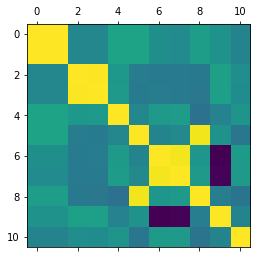

In [33]:
plt.matshow(daily.corr())

There are highly correlate features, some may be discarded. Moreover, some features are redondant.

In [34]:
del columns_descr["Chiffre d'Affaires HT"]

In [35]:
# extract numeric features
num_cols = [
    col 
    for col in columns_descr.keys()
    if np.isreal(daily.loc[start_date, col])
]
num_cols
#scatter_matrix(daily)

["Chiffre d'Affaires TTC",
 'Nombre moyen de produits / Ticket',
 'Ticket moyen TTC',
 'date',
 'dow',
 'day',
 'month',
 'week number',
 'month week number',
 'year',
 'public holidays']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb64a40fe80>,
      dtype=object)

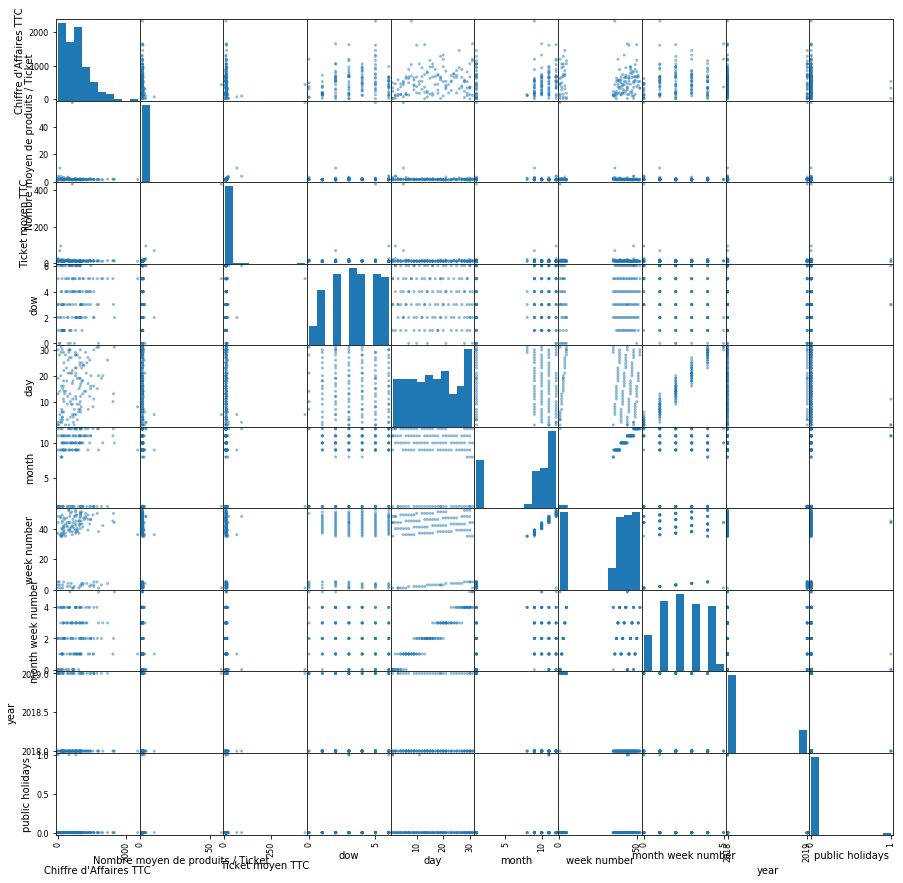

In [36]:
scatter_matrix(daily.loc[:, num_cols], figsize=(15, 15))

 * The Income seems to vary each month
 * There are outliers in income
 * Mean product per transaction and mean transaction number is highly correlated (as expected) except for some days (must be treated separately)
 

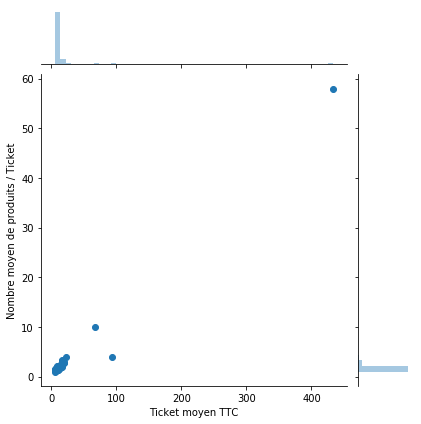

In [37]:
sns.jointplot(
    data=daily,
    x="Ticket moyen TTC",
    y="Nombre moyen de produits / Ticket", 
)

* 3 days with higher mean transaction
* 1 day with the mean product price is higher than usual

### Transaction outliers

The goal of this section is to know if this outliers should be discarded.

In [38]:
daily.loc[daily["Ticket moyen TTC"] > 60]

,Chiffre d'Affaires HT,Chiffre d'Affaires TTC,Nombre moyen de produits / Ticket,Ticket moyen TTC,date,dow,day,month,week number,month week number,year,public holidays
date,,,,,,,,,,,,
2018-09-05,56.00,67.2,10.0,67.2,2018-09-05,2,5,9,36,1,2018,0
2018-12-02,79.47,93.0,4.0,93.0,2018-12-02,6,2,12,48,0,2018,0
2019-01-05,361.99,433.8,58.0,433.8,2019-01-05,5,5,1,1,0,2019,0


One of this 3 outlier correspond to a privatisation. This individual will be discarded.

In [39]:
daily = daily.loc[daily["Ticket moyen TTC"] < 60]
# daily.head()

The opening day should alsobe discarded

In [40]:
daily.loc["2018-09-08"]

Chiffre d'Affaires HT                            1983.69
Chiffre d'Affaires TTC                              2339
Nombre moyen de produits / Ticket                    1.5
Ticket moyen TTC                                    8.57
date                                 2018-09-08 00:00:00
dow                                                    5
day                                                    8
month                                                  9
week number                                           36
month week number                                      1
year                                                2018
public holidays                                        0
Name: 2018-09-08 00:00:00, dtype: object

In [41]:
daily = daily[daily["date"] != "2018-09-08"]

###  Per  month income

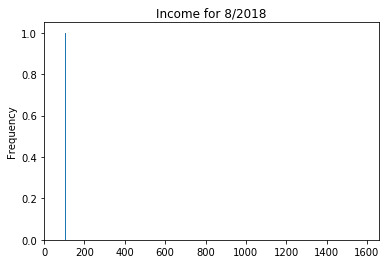

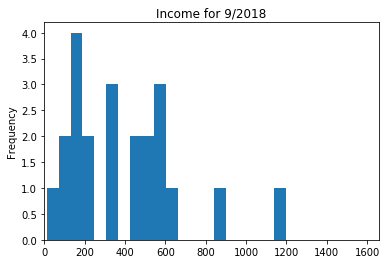

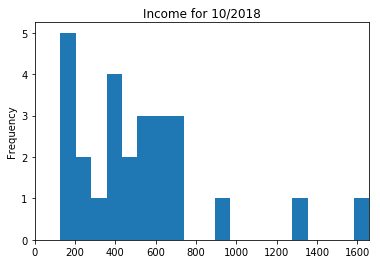

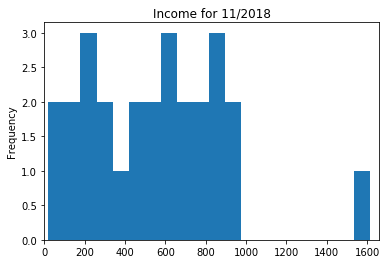

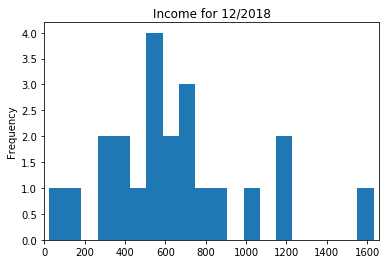

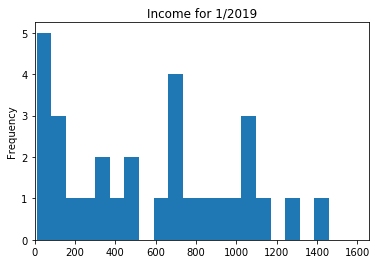

In [42]:
xlim = (0, max(daily["Chiffre d'Affaires TTC"]))
for year, month in product(range(2018, 2020), range(1, 13)):
    cur_data = daily.loc[(daily["month"] == month) & (daily["year"] == year)]
    if len(cur_data) == 0:
        continue
    plt.figure()
    #cur_data["Chiffre d'Affaires TTC"].plot(kind="box",) 
    cur_data["Chiffre d'Affaires TTC"].plot(
        kind="hist", 
        xlim=xlim, 
        title="Income for {}/{}".format(month, year),
        bins=20       
    )

For almost all month, there is one and only one day with high income

In [43]:
daily[daily["Chiffre d'Affaires TTC"] > 1500]

,Chiffre d'Affaires HT,Chiffre d'Affaires TTC,Nombre moyen de produits / Ticket,Ticket moyen TTC,date,dow,day,month,week number,month week number,year,public holidays
date,,,,,,,,,,,,
2018-10-31,1392.13,1659.2,1.6,9.88,2018-10-31,2,31,10,44,5,2018,0
2018-11-10,1370.21,1616.0,1.8,11.14,2018-11-10,5,10,11,45,1,2018,0
2018-12-13,1373.43,1632.4,1.9,12.75,2018-12-13,3,13,12,50,2,2018,0


Each month, one event help raising the income:
* 2018-09-08: opening
* 2018-10-31: halloween
* 2018-11-10: Nabla & JM
* 2018-12-13: Christmas co-plateau
* 2018-01-05: privatisation

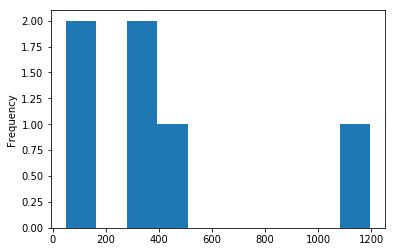

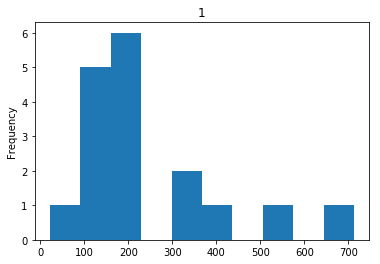

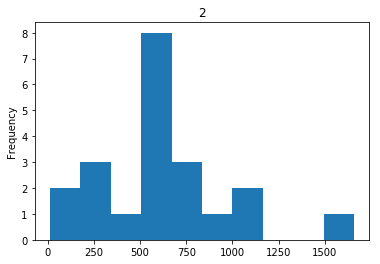

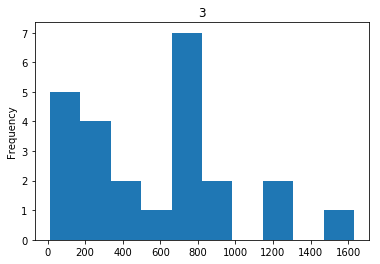

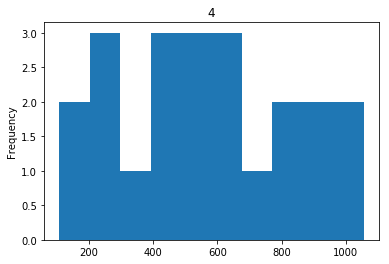

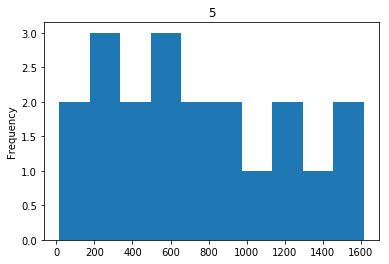

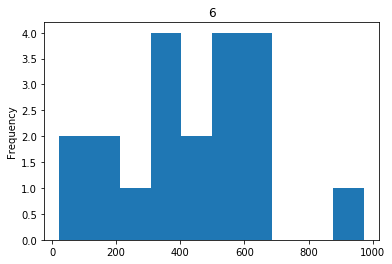

In [44]:
for title, group in daily.groupby("dow"):
    plt.figure()
    group["Chiffre d'Affaires TTC"].plot(kind="hist", title=title)

In [45]:
t = daily.loc[:, ["dow", "Chiffre d'Affaires TTC"]]
t = t.groupby("dow").describe()

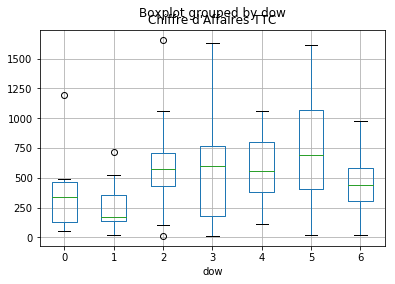

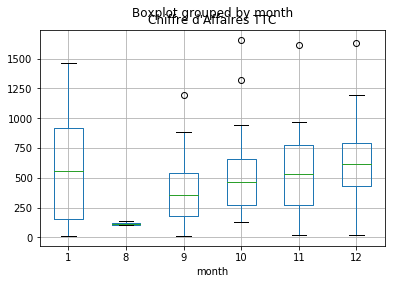

In [46]:
daily.boxplot(column="Chiffre d'Affaires TTC", by="dow")
daily.boxplot(column="Chiffre d'Affaires TTC", by="month")

In [47]:
t = daily.loc[:, ["month", "Chiffre d'Affaires TTC"]]
t = t.groupby("month").describe()

In [48]:
t = daily.loc[:, ["day", "Chiffre d'Affaires TTC"]]
t = t.groupby("day").describe()

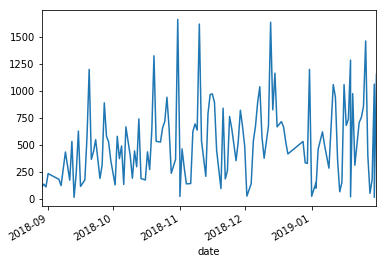

In [49]:
daily["Chiffre d'Affaires TTC"].plot()

This graph denote weekly seasonalities

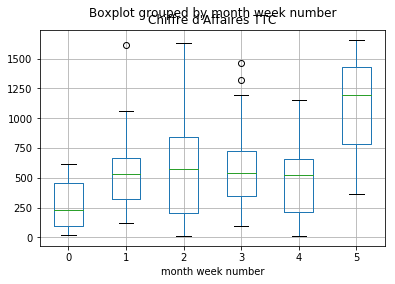

In [50]:
t = daily.loc[:, ["month week number", "Chiffre d'Affaires TTC"]]
t = t.groupby("month week number").describe()
#t.plot(figsize=(15,7))
# t.iloc[:, [4, 5, 6]].plot(figsize=(15,7))
daily.boxplot(column="Chiffre d'Affaires TTC", by="month week number")

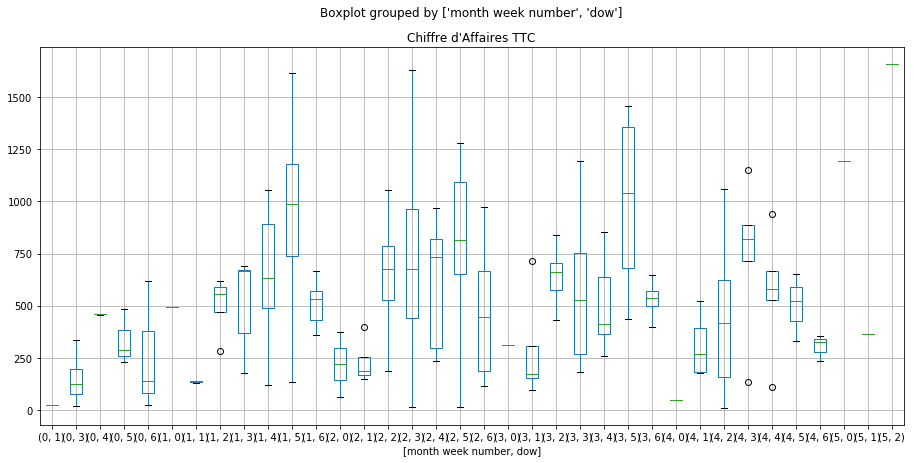

In [51]:
t = daily.loc[:, ["month week number", "dow", "Chiffre d'Affaires TTC"]]
t = t.groupby(["month week number", "dow"]).describe()

# t.iloc[:, [4, 5, 6]].plot(figsize=(15,7))
daily.boxplot(column="Chiffre d'Affaires TTC", by=["month week number", "dow"], figsize=(15, 7))

The 1st friday after the 1st monday of each month is really a good day.

## Predictions

### time series analisis

In [52]:
from datetime import timedelta
from numpy.linalg import LinAlgError
from sklearn.linear_model import LinearRegression
# from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.seasonal import seasonal_decompose

clean serie

In [53]:
t = daily["Chiffre d'Affaires TTC"].resample('1D').mean()
t = t.interpolate()

zeros = pd.Series(0, index=[d for d in pd.date_range(start_date, end_date) if d not in open_days])
for day in zeros.index:
    t[day] = 0

cleaned_daily = t
cleaned_daily.describe()

count     156.000000
mean      439.831859
std       378.640107
min         0.000000
25%       130.450000
50%       399.350000
75%       664.200000
max      1659.200000
Name: Chiffre d'Affaires TTC, dtype: float64

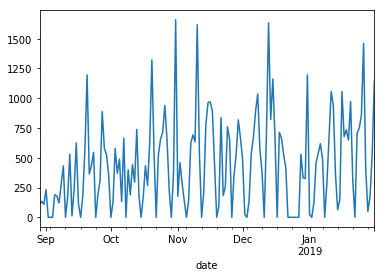

In [54]:
cleaned_daily.plot()

In [55]:
split_date =pd.date_range(start_date, end_date, 5)[3]
daily_X_train_test = pd.DataFrame(cleaned_daily)
daily_X_train, daily_X_test = (
    daily_X_train_test[daily_X_train_test.index < split_date], 
    daily_X_train_test[daily_X_train_test.index >= split_date]
)

detrend

In [56]:
index = np.arange(len(cleaned_daily)).reshape(-1,1)
TREND_REG = LinearRegression().fit(index, cleaned_daily)
trend = TREND_REG.predict(index)


daily_X_train["trend"] = trend
# daily_X_train["detrend"] = cleaned_daily - trend
daily_X_train.describe()

ValueError: Length of values does not match length of index

In [ ]:
daily_X_train.plot(figsize=(15, 7))

In [ ]:
# trend function for forecasts
def forecast_trend(day1):
    """ Return the trend part for the date day
    """
    day0 = daily.index[0]
    day0 = datetime(day0.year, day0.month, day0.day)
    day1 = datetime(day1.year, day1.month, day1.day)
    return TREND_REG.predict(np.array([(day1 - day0).days]).reshape(1, -1))[0]

forecast_trend(datetime.now().date())

seasonalities

In [ ]:
seasons = seasonal_decompose(daily_X_train)
seasonal, trend, residual = seasons.seasonal, seasons.trend, seasons.resid

In [ ]:
daily_X_train["auto trend"] = trend["Chiffre d'Affaires TTC"]
daily_X_train["auto seasonals"] = seasonal["Chiffre d'Affaires TTC"]
daily_X_train["auto residuals"] = residual["Chiffre d'Affaires TTC"]
daily_X_train.plot(figsize=(15, 7))

As expected, there is a weekly seasonality.

In [ ]:
ws = daily_X_train.head(7).copy()
ws["dow"] = list(map(lambda x: x.weekday(), ws.index))
WEEKLY_SEASON = dict(zip(ws["dow"], ws["auto seasonals"]))

def forecast_seasonality(day):
    """Return the seasonality component
    """
    return WEEKLY_SEASON[day.weekday()]

forecast_seasonality(datetime.now())

In [ ]:
trend_season = daily_X_train.copy().reset_index()["date"].apply(
    lambda x: forecast_trend(x) + forecast_seasonality(x)
)

daily_X_train["trend + seasonal"] = list(trend_season)
daily_X_train.loc[:, ["Chiffre d'Affaires TTC", "trend + seasonal"]].plot(figsize=(15,7))

residuals

In [ ]:
#daily_X_train["residual"] = daily_X_train["Chiffre d'Affaires TTC"] - daily_X_train["trend + seasonal"]
daily_X_train["Chiffre d'Affaires TTC"] - daily_X_train["trend + seasonal"]

#daily_X_train["residual"].plot(figsize=(15,7))


In [ ]:
res={}
cleaned_ar = AR(cleaned_daily)

In [ ]:
res = cleaned_ar.fit()
#errors = pd.DataFrame(res).describe()
print(res)
res.k_ar
res.predict(res.params, start=datetime.now())
daily_X_train.index[0], daily_X_train.index[-1]

In [ ]:
order


### spectacle-based

In [ ]:
# TODO:
## data organisation
# each day:
# * fetch ordered list of {spectacle, duration, start_date, type}
# for each spectacle:
# * "chiffre d'affaire TTC"
# --------------------
# for each spectacle predict "chiffre d'affaire"